# Named Entity Recognition BiLSTM-CRF

Named Enity Recognition is one of the most common NLP problems. The goal is classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. What can you use it for? Here are a few ideas - social media, chatbot, customer support tickets, survey responses, and data mining!

Let's start by importing some packages.

In [ ]:
files_path = "./"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

# Training Parameters
We'll set the hyperparameters for training our model.

In [ ]:
# Hyperparams if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

# Data

Let's take a look at data. [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv)

In [ ]:
data = pd.read_csv(f"{files_path}ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-org', 'B-tim', 'I-art', 'I-per', 'B-org', 'B-geo', 'B-art', 'B-nat', 'I-geo', 'B-eve', 'I-tim', 'I-gpe', 'B-per', 'I-eve', 'I-nat', 'B-gpe', 'O']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


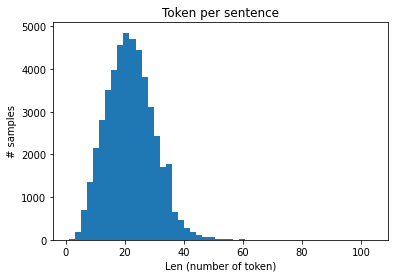

In [ ]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Data Preprocessing
Before feeding the data into the model, we have to preprocess the text.

* We will use the word2idx dictionary to convert each word to a corresponding integer ID and the tag2idx to do the same for the labels. Representing words as integers saves a lot of memory!
* In order to feed the text into our Bi-LSTM-CRF, all texts should be the same length. We ensure this using the sequence.pad_sequences() method and MAX_LEN variable. All texts longer than MAX_LEN are truncated and shorter texts are padded to get them to the same length.
The *Tokens per sentence* plot (see above) is useful for setting the MAX_LEN training hyperparameter.

In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 1322
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 6


Using TensorFlow backend.


Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [26255 30548 27303 25603 13737 29075 18463 23259 32210  2268 23798 33487
 30552 24236   357  2268 15849 30548 29112 31880 22976  7178  1805 27591
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# Model
We will implement a model similar to Zhiheng Huang’s [Bidirectional LSTM-CRF Models for Sequence Tagging.](https://arxiv.org/pdf/1508.01991v1.pdf)

In [ ]:
# Get CRF layer for Tensroflow 2.x
# ! pip install tf2crf
# ! pip install sklearn-crfsuite

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import tensorflow_addons as tfa
from tf2crf import CRF

In [ ]:
# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss, metrics=[crf.accuracy])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 100)           36400     
_________________________________________________________________
time_distributed (TimeDistri (None, 75, 50)            5050      
_________________________________________________________________
crf (CRF)                    (None, 75, 50)            2500      
Total params: 1,451,150
Trainable params: 1,451,150
Non-trainable params: 0
_________________________________________________________________


# Training & Evaluate
*Note:* Accuracy isn't the best metric to choose for evaluating this type of task because most of the time it will correctly predict **'O'** or **'PAD'** without identifing the important Tags, which are the ones we are interested in. So after training for some epochs, we can monitor the **precision**, **recall** and **f1-score** for each of the Tags.

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)

Epoch 1/5
76/76 - 79s - loss: 8.2463 - accuracy: 0.8030 - val_loss: 67.1546 - val_accuracy: 0.8494
Epoch 2/5
76/76 - 79s - loss: 4.3674 - accuracy: 0.8493 - val_loss: 64.7502 - val_accuracy: 0.8648
Epoch 3/5
76/76 - 79s - loss: 2.7135 - accuracy: 0.8859 - val_loss: 62.0125 - val_accuracy: 0.9051
Epoch 4/5
76/76 - 78s - loss: 2.1045 - accuracy: 0.9174 - val_loss: 59.6885 - val_accuracy: 0.9280
Epoch 5/5
76/76 - 79s - loss: 1.6352 - accuracy: 0.9356 - val_loss: 57.3798 - val_accuracy: 0.9467


In [ ]:
hist = pd.DataFrame(history.history)

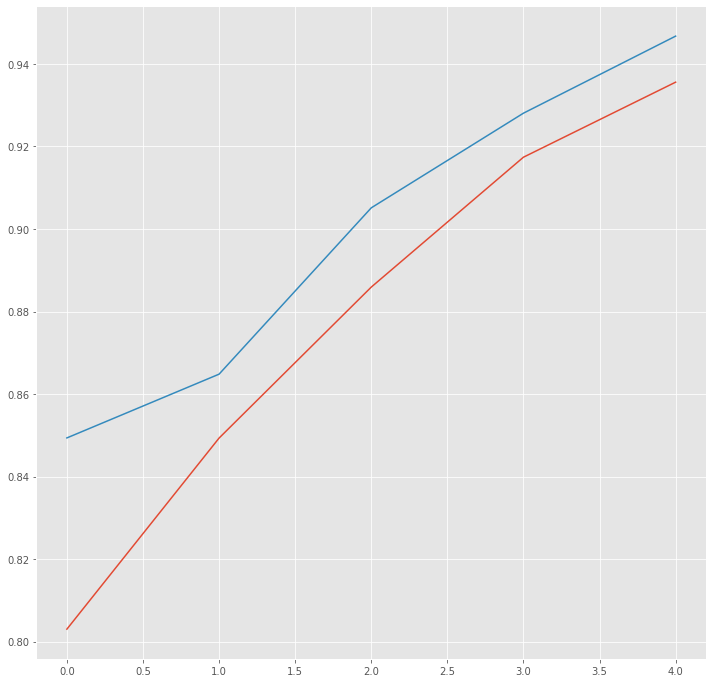

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [ ]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        44
       B-eve       0.00      0.00      0.00        37
       B-geo       0.10      0.89      0.18      3681
       B-gpe       0.50      0.92      0.65      1571
       B-nat       0.00      0.00      0.00        17
       B-org       0.50      0.56      0.53      1994
       B-per       0.54      0.70      0.61      1735
       B-tim       0.08      0.79      0.14      2003
       I-art       0.00      0.00      0.00        32
       I-eve       0.00      0.00      0.00        32
       I-geo       0.04      0.01      0.01       718
       I-gpe       0.00      0.00      0.00        25
       I-nat       0.00      0.00      0.00         5
       I-org       0.09      0.78      0.16      1712
       I-per       0.10      0.14      0.12      1767
       I-tim       0.04      0.01      0.01       647
           O       0.31      0.99      0.48     88476
         PAD       1.00    

Evaluate some samples in the test set. (At each execution it will test on a different sample).

In [ ]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1162 of 4796 (Test Set)
Word           ||True ||Pred
The            : O     O
foreign        : O     O
minister       : O     O
of             : O     O
the            : O     O
ousted         : O     O
Taleban        : B-org B-org
regime         : O     O
in             : O     O
Afghanistan    : B-geo B-geo
has            : O     O
decided        : O     O
to             : O     O
run            : O     O
for            : O     O
a              : O     O
seat           : O     O
in             : O     O
September      : B-tim B-tim
's             : O     O
parliamentary  : O     O
elections      : O     O
.              : O     O


In [ ]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    # Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
    # Evaluation
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    # Visualization
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…

# Save the result

In [ ]:
import pickle

# Saving Vocab
with open('models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
model.save_weights('models/lstm_crf_weights.h5')

# References

[Build a deep learning model for predicting the named entities from text.](https://github.com/floydhub/named-entity-recognition-template)

[A simple CRF layer for tensorflow 2 keras](https://github.com/xuxingya/tf2crf)

[CRF(Conditional Random Field) Layer for TensorFlow 1.X with many powerful functions](https://github.com/howl-anderson/tf_crf_layer)

[Bidirectional LSTM-CRF Models for Sequence Tagging](https://arxiv.org/pdf/1508.01991v1.pdf)

[Building an Incremental Named Entity Recognizer System](http://www.stokastik.in/building-an-incremental-named-entity-recognizer-system/)

[BiLSTM-CRF Sequence Tagging for E-Commerce Attribute Extraction](http://www.stokastik.in/bilstm-crf-sequence-tagging-for-e-commerce-attribute-extraction/)

[BERT-Named Entity Recognizer](https://github.com/cchantra/nlp_tourism/tree/master/more_experiment/restuarant/bert-NER)
